<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Terra 0.7 新機能と変更に関するガイド(New Features and Change Guide)

米国東部時間の2018年12月19日午前9時にQiskit Terra 0.7がリリースされました。本稿では今回のリリースに伴う大きな変更点をいくつかご紹介します。尚[This notebook]( https://github.com/Qiskit/qiskit-tutorials/blob/master/releases/Terra_0.7_New_Features_and_Changes_Guide.ipynb) には本稿に記載されている主な変更点を含む、Terra 0.7の新しい機能や互換性を破る変更 (breaking changes) について、コード例を交えて記載されています。Qiskitをすでにお使いの皆さんには、今回のリリースに伴って大幅に更新されたを[qiskit-tutorial](https://github.com/Qiskit/qiskit-tutorials)下のqiskitとcommunityフォルダを参照してください。


## 重要：0.6からのアップグレードについて(Note on Upgrading)

##<font color=brown>**重要事項**</font>　
今回のリリースでは、はじめに旧バージョンのQiskitのアンインストール（Terraについてのみ）から行ってください。新しいQiskitでは、Terraは `pip install qiskit-terra` Aerは `pip install qiskit-aer`, そして両方を入れる際には`pip install qiskit`を実行する形でpip installのネーミングルールが整理しなおされました。旧バージョンをアンインストールせずに通常のアップデート`pip install -U qiskit`を実行するとエラーが起きる可能性があります。現在お使いのQiskitがsourceからインストールされたものであっても、まずは旧バージョンのアンインストールから行うようにしてください。


0.7のインストールまたは0.6からのアップグレードが完了しましたら、当ガイド内で紹介するデモンストレーションの準備として、まずは以下を実行しておきましょう。

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.tools.qi.qi import qft
import numpy as np
import copy

/Applications/anaconda3/lib/python3.7/site-packages/marshmallow/schema.py:364: ChangedInMarshmallow3Warning: strict=False is not recommended. In marshmallow 3.0, schemas will always be strict. See https://marshmallow.readthedocs.io/en/latest/upgrading.html#schemas-are-always-strict
  ChangedInMarshmallow3Warning


In [2]:
# Setting up a Hadamard QPE circuit for demonstrations below.
def h_qpe(circ, q, n):
    for i in range(n-1):
        circ.h(q[i])
    for j in range(0, n-1, 2): # Only place a CH^n on every other qubit, because CX^n = I for n even
        circ.ch(q[j], q[n-1])
    circ.barrier()
    qft(circ, q, n-1)
    
n = 5
qr = QuantumRegister(n)
cr = ClassicalRegister(n)
circuit = QuantumCircuit(qr, cr)
circuit.rx(np.pi/4, qr[n-1])
circuit.barrier()
h_qpe(circuit, qr, n)
unt_circ = copy.deepcopy(circuit)
circuit.barrier()
circuit.measure(qr, cr)

## シミュレーターのプロバイダーとバックエンド(Providers and Backends)

Quantum Simulator群を３つのプロバイダーに分割しました。

* Aer - 多機能の高性能シミュレーター。別のリポジトリ [here](https://github.com/Qiskit/qiskit-aer)に格納されています。
* BasicAer - Terra内に同梱されているAerの機能制限版です。
* LegacySimulators - Terra 0.6以前の旧シミュレーターです。

In [3]:
%%capture --no-display
from qiskit import BasicAer, LegacySimulators, Aer

qasm_backend = BasicAer.get_backend('qasm_simulator')
sv_backend = BasicAer.get_backend('statevector_simulator')
unt_backend = BasicAer.get_backend('unitary_simulator')

 今回から"qasm_simulator" と "statevector_simulator" のinitialization時にpython版のシミュレーターにfail overさせない仕様になりました。python版のシミュレーターは機能や性能が大幅に制限されていることから、実行に長く時間がかかっていたためです。

## 結果オブジェクト（Results Object)

これまでのdataオブジェクトそのものにアクセスする方法ではなく、accessor メソッドへ移行することで、backend全体にわたってより一貫した安定性のあるインタフェースを提供できるようにしました。

In [4]:
# Setup
from qiskit import execute

qasm_job = execute(circuit, qasm_backend)
sv_job = execute(unt_circ, sv_backend)
unt_job = execute(unt_circ, unt_backend)
qasm_result = qasm_job.result()
sv_result = sv_job.result()
unt_result = unt_job.result()

以下に示すとおり `result.get_data()` メソッドを `result.data()`にrenameしました。 `result.data()`はbackendからデータをas-isで返し、複素数や他の構造にフォーマットされないようにしました。

In [5]:
qasm_result.data()

{'counts': {'0x1b': 26,
  '0x3': 12,
  '0x1': 5,
  '0x11': 20,
  '0x5': 5,
  '0x13': 53,
  '0x1d': 56,
  '0x10': 113,
  '0x17': 2,
  '0xb': 2,
  '0x15': 30,
  '0xf': 1,
  '0x1f': 19,
  '0x0': 670,
  '0xd': 10}}

In [6]:
sv_result.data()

{'statevector': [[0.13529902503654992, 0.7885805074747372],
  [-0.02821286791216001, 0.04222354069865876],
  [0.0, 0.0],
  [-0.020276459301341056, 0.10193664460611457],
  [0.0, 0.0],
  [-0.013548296957796295, -0.06811188834697732],
  [0.0, 0.0],
  [-0.0056118883469774145, -0.008398784439521599],
  [0.0, 0.0],
  [0.008398784439521564, 0.005611888346977307],
  [0.0, 0.0],
  [0.06811188834697726, 0.013548296957796128],
  [0.0, 0.0],
  [-0.10193664460611465, 0.020276459301341233],
  [0.0, 0.0],
  [-0.04222354069865882, 0.028212867912160093],
  [0.05604269114599594, 0.32664074121909403],
  [0.06811188834697726, -0.1019366446061147],
  [0.0, 0.0],
  [0.04895170304220364, -0.2460968299108881],
  [0.0, 0.0],
  [0.03270848226256991, 0.16443664460611454],
  [0.0, 0.0],
  [0.013548296957796246, 0.020276459301341126],
  [0.0, 0.0],
  [-0.02027645930134109, -0.013548296957796219],
  [0.0, 0.0],
  [-0.16443664460611462, -0.03270848226256963],
  [0.0, 0.0],
  [0.24609682991088808, -0.0489517030422039

In [ ]:
unt_result.data()
# Not displayed because results are too large for github.

出力結果は、新しく``get_counts()``, ``get_statevector()``, そして ``get_unitary()`` を result object に対して用います。（旧仕様の``get_data()['counts']``, ``get_data()['statevector']``, and ``get_data()['unitary']``は適用しないでください）

In [7]:
qasm_result.get_counts()

{'11011': 26,
 '00011': 12,
 '00001': 5,
 '10001': 20,
 '00101': 5,
 '10011': 53,
 '11101': 56,
 '10000': 113,
 '10111': 2,
 '01011': 2,
 '10101': 30,
 '01111': 1,
 '11111': 19,
 '00000': 670,
 '01101': 10}

In [8]:
sv_result.get_statevector()

array([ 0.13529903+0.78858051j, -0.02821287+0.04222354j,
        0.        +0.j        , -0.02027646+0.10193664j,
        0.        +0.j        , -0.0135483 -0.06811189j,
        0.        +0.j        , -0.00561189-0.00839878j,
        0.        +0.j        ,  0.00839878+0.00561189j,
        0.        +0.j        ,  0.06811189+0.0135483j ,
        0.        +0.j        , -0.10193664+0.02027646j,
        0.        +0.j        , -0.04222354+0.02821287j,
        0.05604269+0.32664074j,  0.06811189-0.10193664j,
        0.        +0.j        ,  0.0489517 -0.24609683j,
        0.        +0.j        ,  0.03270848+0.16443664j,
        0.        +0.j        ,  0.0135483 +0.02027646j,
        0.        +0.j        , -0.02027646-0.0135483j ,
        0.        +0.j        , -0.16443664-0.03270848j,
        0.        +0.j        ,  0.24609683-0.0489517j ,
        0.        +0.j        ,  0.10193664-0.06811189j])

In [9]:
unt_result.get_unitary()

array([[ 0.13529903+0.78858051j,  0.        +0.j        ,
         0.        +0.j        , ...,  0.        +0.j        ,
         0.        +0.j        ,  0.        +0.j        ],
       [-0.02821287+0.04222354j, -0.47864536+0.18359683j,
         0.04222354+0.02821287j, ...,  0.0135483 -0.02027646j,
        -0.04222354+0.00111627j, -0.02027646-0.0135483j ],
       [ 0.        +0.j        ,  0.        +0.j        ,
        -0.44212568+0.27880531j, ...,  0.        +0.j        ,
         0.04783543-0.11548494j, -0.01981408-0.0874636j ],
       ...,
       [ 0.24609683-0.0489517j ,  0.06811189+0.03034587j,
        -0.0489517 -0.24609683j, ..., -0.06811189+0.0135483j ,
         0.08727207+0.08277646j,  0.0135483 +0.06811189j],
       [ 0.        +0.j        ,  0.        +0.j        ,
         0.2111558 +0.04783543j, ...,  0.        +0.j        ,
        -0.04783543+0.01981408j, -0.11548494+0.18313445j],
       [ 0.10193664-0.06811189j,  0.21227207+0.00561189j,
         0.06811189+0.10193664

出力結果は、resultオブジェクトのpost-processed methodsを通じてやり取りをします。（今回から、``len()`` や``Result``オブジェクトの indexingが取り除かれました。）

In [10]:
len(sv_result.get_statevector())

32

``Result`` class からメソッド``get_snapshot()`` と ``get_snapshots()``が削除されました。バックエンドに投げられたsnapshotは、シミュレーターの自由裁量で操作可能で、``Result.data()['snapshots']``をつかってsnapshotがアクセスできるようになりました。 

In [11]:
from qiskit import LegacySimulators
from qiskit.extensions.simulator.snapshot import snapshot
snap_backend = LegacySimulators.get_backend('statevector_simulator')

snap_unt_circ = copy.deepcopy(unt_circ)
snap_unt_circ.snapshot(10)
sv_job = execute(snap_unt_circ, snap_backend)
sv_result = sv_job.result()
sv_result.data()['snapshots']

/Applications/anaconda3/lib/python3.7/site-packages/qiskit/providers/legacysimulators/legacyprovider.py:41: DeprecationWarning: Simulators in the LegacySimulators provider are deprecated. If you want
 maximum compatibility, you can use those in the Simulators provider. If you want to make the most
 of performance, consider installing the Qiskit Aer element and user the Aer provider.
  warnings.warn(DEPRECATION_MSG, DeprecationWarning)
/Applications/anaconda3/lib/python3.7/site-packages/qiskit/providers/legacysimulators/legacyprovider.py:37: DeprecationWarning: Simulators in the LegacySimulators provider are deprecated. If you want
 maximum compatibility, you can use those in the Simulators provider. If you want to make the most
 of performance, consider installing the Qiskit Aer element and user the Aer provider.
  warnings.warn(DEPRECATION_MSG, DeprecationWarning)


{'statevector': {'10': [[[0.1352990250365496, 0.7885805074747372],
    [-0.02821286791216005, 0.04222354069865875],
    [4.289610691196225e-17, -3.248776605610142e-17],
    [-0.02027645930134106, 0.10193664460611457],
    [-5.397192826725481e-17, -1.1285039546789633e-16],
    [-0.013548296957796316, -0.06811188834697732],
    [-9.392163370600625e-18, 3.571064700479636e-17],
    [-0.005611888346977376, -0.00839878443952159],
    [-4.163336342344337e-17, 0.0],
    [0.008398784439521564, 0.005611888346977307],
    [-1.2627434885189043e-18, 1.167108434437975e-17],
    [0.06811188834697725, 0.013548296957796184],
    [-1.3247655120144348e-16, 1.1285039546789633e-16],
    [-0.10193664460611462, 0.020276459301341185],
    [-4.485624437213816e-18, 4.0617185938183144e-17],
    [-0.04222354069865883, 0.028212867912160114],
    [0.0560426911459959, 0.32664074121909403],
    [0.06811188834697728, -0.10193664460611472],
    [-8.375985885340412e-18, -1.283607757691177e-17],
    [0.04895170304220362,

### オブザーバブルに対応した平均値について　（Averages with Respect to Observables)

`average_data(self, name, observable)` は非推奨となり、一般的な量子状態の計測やオブザーバブルのために利用できるよう、quantum_info sectionへと移動されました。

In [12]:
from qiskit.quantum_info.analyzation.average import average_data

In [13]:
counts = qasm_result.get_counts()
iden = np.eye(len(counts))
oper = {}
for i, key in enumerate(counts.keys()):
    oper[key] = iden[i]
average_data(counts, oper)

array([0.02539062, 0.01171875, 0.00488281, 0.01953125, 0.00488281,
       0.05175781, 0.0546875 , 0.11035156, 0.00195312, 0.00195312,
       0.02929688, 0.00097656, 0.01855469, 0.65429688, 0.00976562])

## ビジュアライゼーション (Visualization)

Qiskitのインストールにおける前提条件や構成をよりシンプルにするために、リリース0.7のビジュアライゼーションにおいて、TerraのMatplotlibとの依存関係をなくしました。

今後もCircuit drawaerのmplアウトプットやqiskit.tools.visualizationモジュールにふくまれるplot*関数を使いたいユーザーは、ご自身でmatplotlibのインストールを行うようにしてください。　

また、Qiskitインストール時に以下のオプションを指定することで、ビジュアライゼーションに関係する必要なモジュールを一緒にインストールすることも可能です。

In [14]:
#!pip install qiskit-terra[visualization]

In [15]:
from qiskit.tools.visualization import circuit_drawer
from qiskit.tools.visualization.dag_visualization import dag_drawer

### サーキット・ドローイング（Circuit Drawing)

Circuit Drawingの詳細については、Matthew Treinishが作成したnotebook  [Visualizing a Quantum Circuit](https://github.com/Qiskit/qiskit-tutorials/blob/master/qiskit/terra/visualizing_a_quantum_circuit.ipynb) の参照を推奨します。

今回から `QuantumCircuit` オブジェクトに`circuit.draw()`メソッド が追加され、出力フォーマットはよりシンプルで拡張性のあるASCIIコードになりました。ここでは回路全体がnotebookの横幅に収まるようlin_lenを調整しています。(**注:** githubはnotebookの水平方向へのスクローリングができない仕様のため）

In [16]:
lin_len = 98
# Change to wider in Jupyter, this is only to render nicely in github
circuit.draw(line_length=lin_len)

オプション指定なしの場合、circuit.draw() はデフォルトでASCIIコードでアウトプットを出力します。Matplotlib, LaTeX, そして``latex_source``もサポートされており機能がさらに充実化されています。

（注：``style`` kwarg dictの``plot_barriers`` と　``reverse_bits`` キー は非推奨となりました。今後は`qiskit.tools.visualization.circuit_drawer()` kwargs の ``plot_barriers`` と``reverse_bits`` をご利用ください）

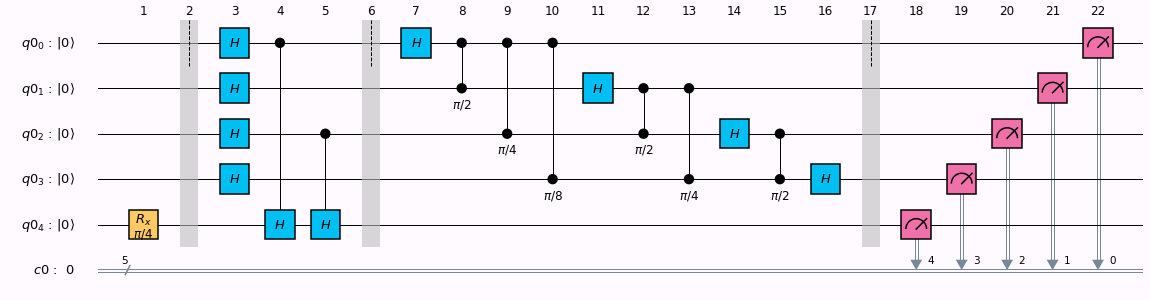

In [18]:
style = {'cregbundle': True, 'usepiformat': True, 'subfontsize': 12, 'fold': 100, 'showindex': True,
         'backgroundcolor': '#fffaff',
         "displaycolor": { # Taken from qx_color_scheme() in _circuit_visualization.py
            "id": "#ffca64",
            "u0": "#f69458",
            "u1": "#f69458",
            "u2": "#f69458",
            "u3": "#f69458",
            "x": "#a6ce38",
            "y": "#a6ce38",
            "z": "#a6ce38",
            "h": "#00bff2",
            "s": "#00bff2",
            "sdg": "#00bff2",
            "t": "#ff6666",
            "tdg": "#ff6666",
            "rx": "#ffca64",
            "ry": "#ffca64",
            "rz": "#ffca64",
            "reset": "#d7ddda",
            "target": "#00bff2",
            "meas": "#f070aa"}}
circuit.draw(output='mpl', style=style)

以下はlatex_sourceを使ったcircuit drawの例です。

In [19]:
circuit.draw(output='latex_source', plot_barriers=False)

'% \\documentclass[preview]{standalone}\n% If the image is too large to fit on this documentclass use\n\\documentclass[draft]{beamer}\n% img_width = 10, img_depth = 21\n\\usepackage[size=custom,height=15,width=39,scale=0.7]{beamerposter}\n% instead and customize the height and width (in cm) to fit.\n% Large images may run out of memory quickly.\n% To fix this use the LuaLaTeX compiler, which dynamically\n% allocates memory.\n\\usepackage[braket, qm]{qcircuit}\n\\usepackage{amsmath}\n\\pdfmapfile{+sansmathaccent.map}\n% \\usepackage[landscape]{geometry}\n% Comment out the above line if using the beamer documentclass.\n\\begin{document}\n\\begin{equation*}\n    \\Qcircuit @C=0.5em @R=0.0em @!R {\n\t \t\\lstick{q0_{0}: \\ket{0}} & \\gate{H} & \\ctrl{4} & \\gate{H} & \\control\\qw & \\dstick{1.6}\\qw & \\control\\qw & \\dstick{0.79}\\qw & \\control\\qw & \\dstick{0.39}\\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\qw & \\meter & \\qw & \\qw\\\\\n\t \t\\lstick{q0_{1}: \\ke

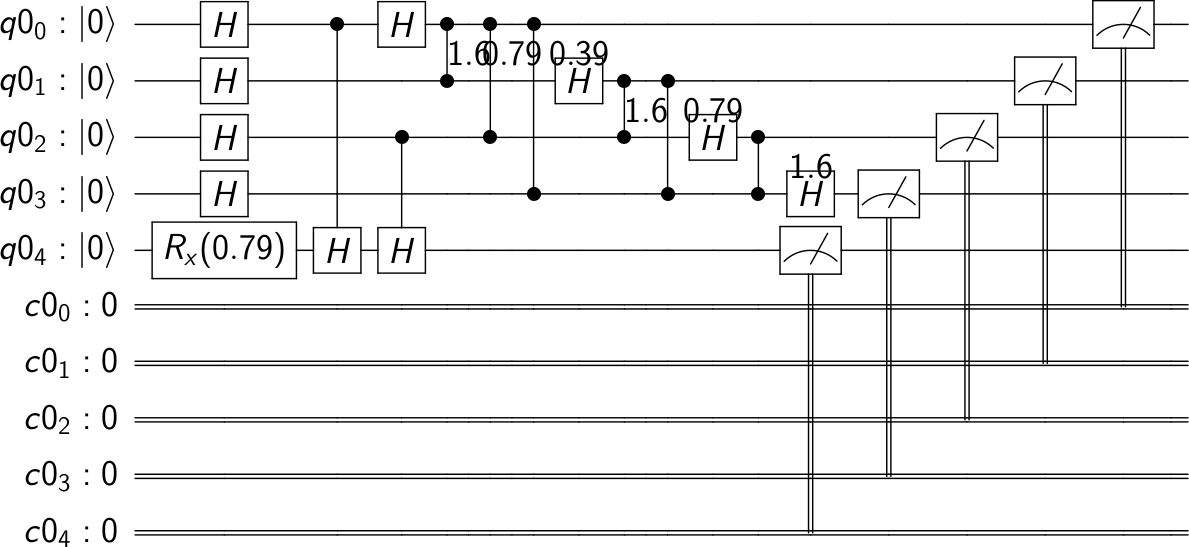

In [20]:
circuit.draw(output='latex', plot_barriers=False)

circuit_drawer(circuit)もこれまで通りお使いいただけますが、``circuit_drawer()`` 関数内の``basis`` kwarg は取り除かれました。標準的な実行方法としては、最初にTranspilingを行います。

In [21]:
from qiskit import transpiler

In [ ]:
draw_circ = transpiler.transpile(circuit, qasm_backend, basis_gates='U,CX')
draw_circ.draw(line_length=2000)
# Not shown in github for rendering reasons, load in Jupyter

今後は`circuit.draw()` と ``circuit_drawer()`` のみがビジュアライゼーション・モジュールにおけるサーキットドローイングのインタフェースになります。0.6で提供されていたqiskit.tools.visualization の``plot_circuit()``, ``latex_circuit_drawer()``, ``generate_latex_source()``, そして ``matplotlib_circuit_drawer()`` は非推奨となります。同モジュールの ``circuit_drawer()`` をお使いください。非推奨となった関数と同等の機能はkwarg オプションで提供されます。

### 量子状態のビジュアライゼーション（State Visualization）

1. `plot_state()` と`iplot_state()` は非推奨となりました。下記に示すとおり、必要なビジュアライゼーション・メソッド の呼び出しには、 `plot_state_*()` と `iplot_state_*()` を用いてください。
 
2. `plot_state_*()` 関数の出力が変わりました。以前は`plot_state_*()` を呼び出すとmatplotlibとの依存関係から,新規ウインドウが立ち上がってビジュアライゼーションの出力結果が表示されましたが、今後は保存や表示を行う以前に``matplotlib.Figure`` objectを返す仕様となり、より柔軟な対応が可能になります。（以前と同様の表示方法を再現するには 0.7移行では、``show()`` を実行する必要があります。）

In [22]:
from qiskit.tools.qi.qi import outer
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.visualization import iplot_histogram, iplot_state_city, iplot_bloch_multivector, iplot_state_paulivec, iplot_state_hinton, iplot_state_qsphere

In [23]:
counts = qasm_result.get_counts()
phi = sv_result.get_statevector()
rho = outer(phi)

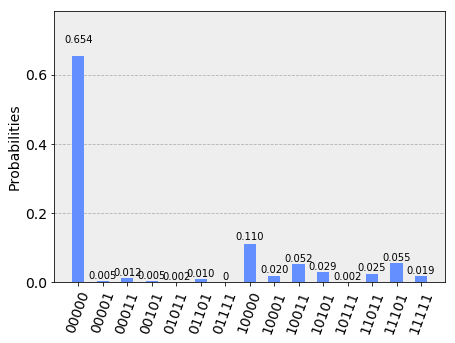

In [24]:
plot_histogram(counts)

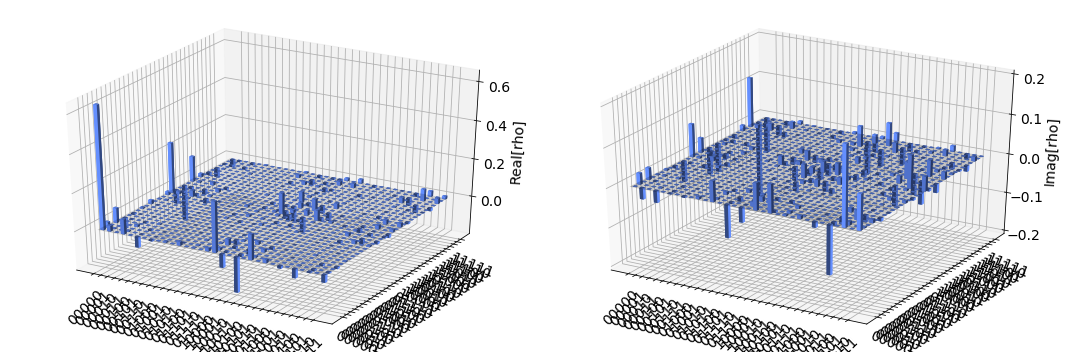

In [25]:
plot_state_city(rho)

新しくヒントンダイヤグラム(Hinton Diagram)が追加されました。

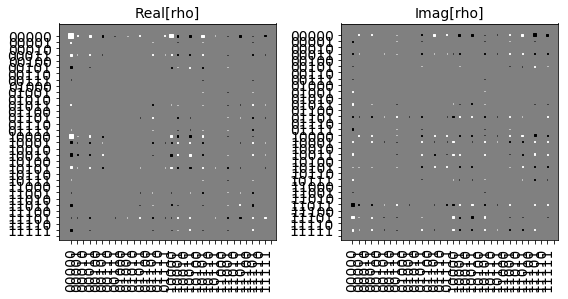

In [26]:
plot_state_hinton(rho)

今回Figure Objectを返す仕様となったことにより、アウトプットに対してより柔軟に対応できるようになりました。
例えば、figureの表示をする代わりに下記のように ``savefig()`` methodをつかって直接ファイルとしてローカルに保存することができます。

In [27]:
hist_fig = plot_histogram(counts)
state_fig = plot_state_city(rho)
hist_fig.savefig('histogram.png')
state_fig.savefig('state_plot.png')

これらの関数に関連して大きく変わったのはjupyter notebook上で実行を行うときです。
0.6では、ビジュアライゼーションのレンダリングに必要となる外部にホスティングされたJavascriptライブラリがネットワーク越しに使える状態のときは、デフォルトでJavascript plotsをインタラクティブに使い、それらにアクセスできないときはmatplotlib版のplotに切り替えて使う仕様でした。
0.7ではインタラクティブにplotするときは、``iplot_state()`` と``iplot_histogram()``を用いてください. ``plot_state()`` と``plot_histogram()`` を使うときは常に matplotlib versionsを使ってください。 

In [ ]:
iplot_bloch_multivector(rho)
# Not displayed in github, download and run loacally.

加えて今回のリリース以降は ``plot_state()`` 関数は非推奨となり、量子状態のplotを行う際は下記表のあるように、各々のメソッドを呼び出す形が推奨されます。（注： ``plot_state()`` 関数はリリース0.9までは継続して使うことが可能ですが、使うたびにwarningメッセージが表示されます。）

```
==================================  ========================
Qiskit Terra 0.6                    Qiskit Terra 0.7+
==================================  ========================
plot_state(rho)                     plot_state_city(rho)
plot_state(rho, method='city')      plot_state_city(rho)
plot_state(rho, method='paulivec')  plot_state_paulivec(rho)
plot_state(rho, method='qsphere')   plot_state_qsphere(rho)
plot_state(rho, method='bloch')     plot_bloch_multivector(rho)
plot_state(rho, method='hinton')    plot_state_hinton(rho)
==================================  ========================
```

``iplot_state()``をつかったJavascriptによるインタラクティブなplotを行う際も上記と同様のルールが適応されます。関数名は同じですが接頭に `i` を付記します。（例：``iplot_state(rho, method='paulivec')`` は``iplot_state_paulivec(rho)``　となります。）

最後に、今回のリリースからDAGCircuit drawerも新しく追加されました。

In [28]:
from qiskit.converters.circuit_to_dag import circuit_to_dag

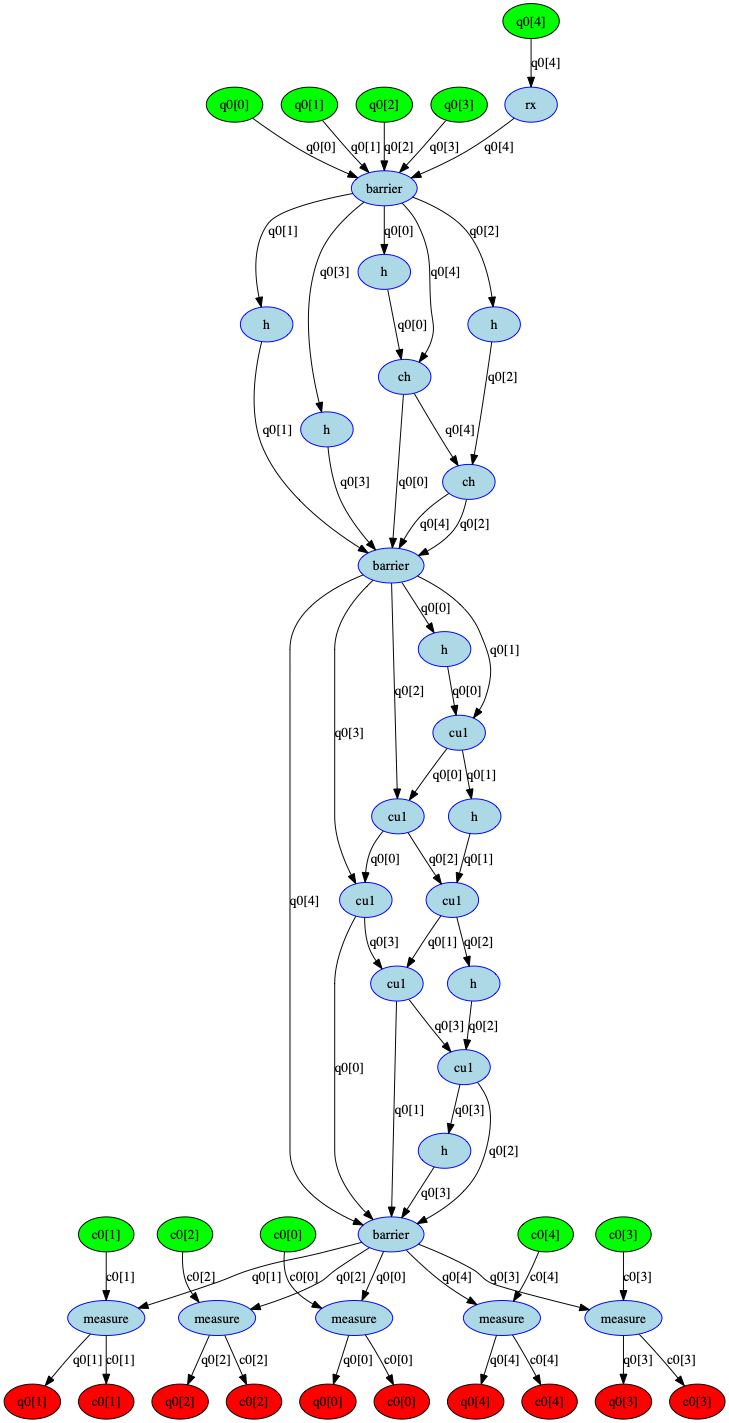

In [29]:
my_dag = circuit_to_dag(circuit)
dag_drawer(my_dag)

## ショット・メモリについて（Shot Memory）

Shot memory は Quantum hardwareやshot-basedのシミュレーターでjobを走らせたときのshot resultのログです。ハードウェアの動作特性や解析に役立つ情報として追加されました。Shot memoryを使うには、execute関数のなかでmemory=Trueを指定してください。

In [30]:
job = execute(circuit, qasm_backend, shots=50, memory=True)

result = job.result()
result.get_memory(circuit)

['00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '10011',
 '00000',
 '10101',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00000',
 '00101',
 '11011',
 '10000',
 '00000',
 '00000',
 '00000',
 '00000',
 '10000',
 '11011',
 '00000',
 '00000',
 '00000',
 '00000',
 '10011',
 '00000',
 '00000',
 '01011',
 '00000',
 '10011',
 '00000',
 '00000',
 '10011',
 '10011',
 '00000',
 '10000',
 '00000',
 '00000',
 '00000',
 '11011',
 '00000',
 '00000']

## トランスピレーションとDAGCircuit (Transpilation and the DAGCircuit)

トランスパイラはTerraの心臓部であり、作成した量子回路の可用性を高め、任意の量子ハードウェアとの互換性を保てるようにしています。今回、より洗練されたメソッドにも対応できるよう、トランスパイラを堅牢かつ拡張性のあるものに改変しました。

circuit  -> DAGCircuitsではなく、トランスパイラはcircuit -> circuitにトランスパイルを行うように変わり、各トランスパイラが回路にどのように作用しているのかがはっきり分かるようにしました。

以下はIBMのハードウェアにうまくフィットしない回路の例です。

In [31]:
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import BasicSwap, CXCancellation, LookaheadSwap, StochasticSwap
from qiskit.transpiler import transpile
from qiskit.mapper import CouplingMap

In [32]:
qr = QuantumRegister(7, 'q')
qr = QuantumRegister(7, 'q')
tpl_circuit = QuantumCircuit(qr)
tpl_circuit.h(qr[3])
tpl_circuit.cx(qr[0], qr[6])
tpl_circuit.cx(qr[6], qr[0])
tpl_circuit.cx(qr[0], qr[1])
tpl_circuit.cx(qr[3], qr[1])
tpl_circuit.cx(qr[3], qr[0])
tpl_circuit.draw()

一つのやり方としては、ひたすらswapを適応してqubitを操作する方法です。ここではBasicSwapをつかって実行してみます。

In [33]:
coupling = [[0, 1], [1, 2], [2, 3], [3, 4], [4, 5], [5, 6]]

simulator = BasicAer.get_backend('qasm_simulator')
coupling_map = CouplingMap(couplinglist=coupling)
pass_manager = PassManager()
pass_manager.append([BasicSwap(coupling_map=coupling_map)])
basic_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
basic_circ.draw()

あまり良い方法とは言えません。それでは、2018 QISKit Developer Challengeに投稿されたSven JanduraさんのLookaheadSwapをみてみましょう。 Svenさんの swap passはTerraにマージされました。（ちなみに、Qiskit Developer Challengeに応募し当選した投稿者のpassが近日中にあと２つマージされる予定です。 今後もcircuit mappingの多様なニーズに適応するために、様々なpassセットをユーザーの皆さんの力を借りながら充実化させていきます。）

In [34]:
pass_manager = PassManager()
pass_manager.append([LookaheadSwap(coupling_map=coupling_map)])
lookahead_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
lookahead_circ.draw()

さきほどよりも良いですね！それでは、 StochasticSwapをつかってもう一度試してみましょう。

In [35]:
pass_manager = PassManager()
pass_manager.append([StochasticSwap(coupling_map=coupling_map)])
stoch_circ = transpile(tpl_circuit, simulator, pass_manager=pass_manager)
stoch_circ.draw()

更に良くなりました。でも、まだ改良の余地はあります。これまでは、今確認してきたような操作の結果は、ユーザーからは見えないところで起こっていました。今後はこれらのツールによって、トランスピレーションの及ぼす作用とのその結果を透明化し、量子ハードウェア上の実験において、より高いパフォーマンスを実現しようとするユーザーのニーズに応えていきたいと考えています。

### パスマネージャー (PassManager)

0.7ではPassManagerを大きく更新しました。トランスパイラのパスの適応や変更をわかりやすく拡張性をもってできるようになりました。但し、あいにく当更新については本稿内で取り扱うには大きすぎるトピックのため、トランスパイラの更新を担当したAli Jaavadi-Abhariが “Writing a Transpiler Pass” というタイトルの記事を近くブログに掲載し詳細に紹介する予定です。

### `skip_transpiler`について  (`skip_transpiler`)

``compile()`` and ``execute()``の``skip_transpiler`` arg は非推奨となりました。代わりに、以下のように空のPassManager を`execute()`, `compile()`,または`transpile()`, に渡します。

In [36]:
qasm_job = execute(circuit, qasm_backend, pass_manager=PassManager())

### コンバーターと ``transpile_dag()``（Converters and ``transpile_dag()``)


QuantumCircuit, DAGCircuit, Qobj, そして astといった主要なcircuitフォーマット間の相互変換を行うためのコンバーターを導入しました。

異なるフォーマットで出力結果を出すための ``transpile_dag()`` 関数の ``format`` kwarg は非推奨となりました。今後は default output ``DAGCircuit`` オブジェクトを希望のフォーマットで出力するようにしてください。

In [37]:
from qiskit.converters.dag_to_circuit import dag_to_circuit

In [38]:
new_circ_from_dag = dag_to_circuit(my_dag)
new_circ_from_dag.draw(line_length = lin_len)

### アンローリング (Unrolling)

トランスパイラ内での展開（アンロール）を実施することにより、アンローラはサポートされなくなりました。今後はDAG -> DAGのアンローリングのみサポートされます。

```
    draw_circ = transpiler.transpile(circuit, qasm_backend, basis_gates='U,CX')
```

## その他

### QASM を回路にロードする (Loading QASM into Circuits)

`qiskit.wrapper.load_qasm_string()` と `qiskit.wrapper.load_qasm_file()`は非推奨となります。今後は以下のQuantumCircuit constructor メソッドを用いてください。

In [39]:
from qiskit import QuantumCircuit

In [40]:
qasm_str = circuit.qasm()
new_circ = QuantumCircuit.from_qasm_str(qasm_str)
new_circ.draw(line_length = lin_len)

In [41]:
filepath = 'my_qasm_file.txt'
qasm_file = open(filepath, "w")
qasm_file.write(unt_circ.qasm())
qasm_file.close()

new_unt_circ = QuantumCircuit.from_qasm_file(filepath)
new_unt_circ.draw(line_length = lin_len)